# Exploratory Data Analysis: Stock Returns & Volatility

This notebook performs exploratory data analysis for a stock market prediction dataset covering 14 tickers from 2015 to present, with a focus on next-day direction and next-day volatility spikes. The EDA validates label construction, summarizes return distributions and volatility environments, and motivates time-based evaluation (walk-forward or expanding-window splits) with metrics for spike prediction. Because stock data is noisy, the analysis emphasizes market environment behavior and highlights features that may carry predictive signal. All features are constructed using information available up to time t to avoid data leakage.

### Key takeaways from this EDA:
- Direction requires baseline-first evaluation. Always-Up accuracy provides the minimum benchmark, and performance must be stable across time splits.
- VolSpike is imbalanced. The accuracy can be misleading, so the primary metrics will be precision/recall and PR-AUC.
- Validation must be time-based (walk-forward or expanding window) to reflect real forecasting conditions and avoid leakage from random shuffling.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set visual style for consistent plots where applicable
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
plt.rcParams["figure.figsize"] = (12, 6)

## Data Snapshot

The dataset contains daily price data, technical indicators, and VIX, aligned so that features at day $t$ predict outcomes at day $t+1$. The analysis uses two versions of the data:

- **Full dataset**: All price data from January 2015 onwards (used for price history visualization)
- **Clean dataset**: Complete features from July 2015 onwards (used for feature analysis and modeling)

The clean dataset covers 36,000+ trading days across 5 sectors (Technology, Finance, Defense, Energy, Transportation).

In [22]:
# Load both datasets
df_full = pd.read_csv("data/merged_features_full.csv")
df_full["Date"] = pd.to_datetime(df_full["Date"])

df = pd.read_csv("data/merged_features_clean.csv")
df["Date"] = pd.to_datetime(df["Date"])

print("Full dataset (for price history):")
print(f"Date range: {df_full['Date'].min().date()} to {df_full['Date'].max().date()}")
print(f"Rows: {len(df_full):,}")
print(f"\nClean dataset (for feature analysis and modeling):")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Rows: {len(df):,}")

df.head()

Full dataset (for price history):
Date range: 2015-01-02 to 2025-12-26
Rows: 38,682

Clean dataset (for feature analysis and modeling):
Date range: 2015-07-17 to 2025-12-24
Rows: 36,778


,Date,Ticker,Close,High,Low,Open,Volume,Return,RollingVol,RSI,Price_to_SMA20,Price_to_SMA50,SMA20_to_SMA50,Volume_Z,VIX,Lagged_Return,Direction,VolSpike
0,2015-07-17,AAPL,28.969582,28.969582,28.676802,28.848895,184658800,0.008637,0.016381,59.275631,1.028554,1.014973,0.986796,0.209108,11.95,0.008637,1,0
1,2015-07-20,AAPL,29.517155,29.718300,29.210962,29.271307,235600800,0.018902,0.016975,64.539780,1.045726,1.033056,0.987884,1.110108,12.25,0.018902,0,1
2,2015-07-21,AAPL,29.222134,29.707120,29.126032,29.691477,307025600,-0.009995,0.017494,60.036926,1.033989,1.022230,0.988628,2.005310,12.22,-0.009995,0,1
3,2015-07-22,AAPL,27.986206,28.048785,27.264312,27.264312,461802400,-0.042294,0.021186,45.663651,0.990966,0.979164,0.988090,3.038030,12.12,-0.042294,0,1
4,2015-07-23,AAPL,27.972795,28.404142,27.950444,28.205230,203998000,-0.000479,0.019694,45.536262,0.991649,0.978804,0.987046,0.060208,12.64,-0.000479,0,1


In [23]:
df.info()
print("\nStatistical Summary")
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36778 entries, 0 to 36777
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            36778 non-null  datetime64[ns]
 1   Ticker          36778 non-null  object        
 2   Close           36778 non-null  float64       
 3   High            36778 non-null  float64       
 4   Low             36778 non-null  float64       
 5   Open            36778 non-null  float64       
 6   Volume          36778 non-null  int64         
 7   Return          36778 non-null  float64       
 8   RollingVol      36778 non-null  float64       
 9   RSI             36778 non-null  float64       
 10  Price_to_SMA20  36778 non-null  float64       
 11  Price_to_SMA50  36778 non-null  float64       
 12  SMA20_to_SMA50  36778 non-null  float64       
 13  Volume_Z        36778 non-null  float64       
 14  VIX             36778 non-null  float64       
 15  La

,Date,Close,High,Low,Open,Volume,Return,RollingVol,RSI,Price_to_SMA20,Price_to_SMA50,SMA20_to_SMA50,Volume_Z,VIX,Lagged_Return,Direction,VolSpike
count,36778,36778.000000,36778.000000,36778.000000,36778.000000,3.677800e+04,36778.000000,36778.000000,36778.000000,36778.000000,36778.000000,36778.000000,36778.000000,36778.000000,36778.000000,36778.000000,36778.000000
mean,2020-10-03 13:06:36.041111552,128.650758,130.060950,127.175996,128.635422,6.392856e+07,0.001014,0.018305,53.917112,1.007987,1.020561,1.011571,0.000976,18.498748,0.001014,0.528142,0.252270
min,2015-07-17 00:00:00,0.467273,0.472596,0.461949,0.465821,1.912000e+05,-0.302902,0.002029,14.600090,0.390627,0.300059,0.542509,-2.935436,9.140000,-0.302902,0.000000,0.000000
25%,2018-02-23 00:00:00,44.919764,45.471174,44.389999,44.939307,6.544050e+06,-0.008150,0.010093,45.211271,0.982374,0.977076,0.985974,-0.703872,13.560000,-0.008150,0.000000,0.000000
50%,2020-10-02 00:00:00,80.434345,81.249947,79.539753,80.427606,1.878885e+07,0.000937,0.014861,54.022934,1.009156,1.021122,1.012955,-0.252299,16.700001,0.000937,1.000000,0.000000
75%,2023-05-15 00:00:00,176.818760,178.752545,174.636753,176.516325,5.575768e+07,0.010224,0.022366,62.720161,1.033896,1.062983,1.037979,0.468904,21.510000,0.010224,1.000000,1.000000
max,2025-12-24 00:00:00,635.374756,638.312894,628.821334,635.424576,3.692928e+09,0.298067,0.186577,94.197983,1.702448,1.952599,1.317392,4.232049,82.690002,0.298067,1.000000,1.000000
std,NaN,122.119240,123.353638,120.837093,122.112864,1.360274e+08,0.022313,0.012911,12.400722,0.053877,0.087073,0.052884,1.055064,7.255783,0.022313,0.499214,0.434321


## Coverage

| Sector | Equity Tickers | Economic Driver |
| :--- | :--- | :--- |
| Technology | AAPL, MSFT, NVDA, GOOGL, AMZN, TSLA | Innovation & Growth |
| Finance | JPM | Interest Rates & Credit Cycles |
| Retail | WMT | Consumer Spending |
| Defense | LMT, RTX, NOC | Geopolitical Cycles |
| Energy | XOM | Commodity Pricing |
| Airlines | DAL, UAL | Fuel Costs & Tourism |

### Price History

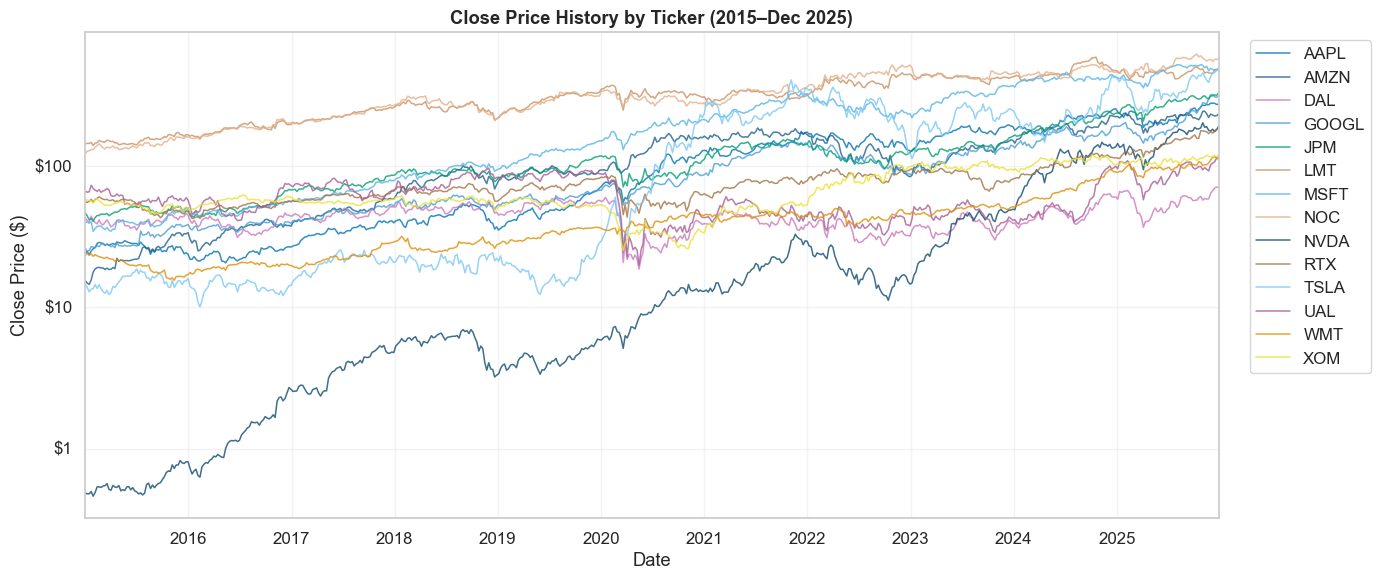

In [24]:
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

fig, ax = plt.subplots(figsize=(14, 6))

# Sector-based colorblind-friendly palette for the tickers
ticker_colors = {
    'AAPL': '#0173B2', 'MSFT': '#56B4E9', 'NVDA': '#0D4A70',
    'GOOGL': '#4A9ED6', 'AMZN': '#1E5F8C', 'TSLA': '#7CC8F5',
    'JPM': '#029E73', 'WMT': '#DE8F05',
    'DAL': '#CC78BC', 'UAL': '#A65C94',
    'LMT': '#CA9161', 'RTX': '#A37345', 'NOC': '#E3AF89',
    'XOM': '#ECE133'
}

# Weekly data to reduce clutter, filter out invalid prices for log scale
df_plot = (df_full[df_full["Close"] > 0]
             .sort_values(["Ticker", "Date"])
             .groupby(["Ticker", pd.Grouper(key="Date", freq="W-FRI")])["Close"]
             .last()
             .reset_index())

# Plot each ticker
for ticker in sorted(df_plot["Ticker"].unique()):
    subset = df_plot[df_plot["Ticker"] == ticker]
    ax.plot(subset["Date"], subset["Close"], 
            label=ticker, color=ticker_colors[ticker],
            alpha=0.8, linewidth=1.1)

start_date = df_plot["Date"].min().strftime("%Y")
end_date = df_plot["Date"].max().strftime("%b %Y")
ax.set_title(f"Close Price History by Ticker ({start_date}–{end_date})", fontweight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price ($)")

# Log scale for percentage-based comparison
ax.set_yscale("log")  

# Remove white space on edges
ax.margins(x=0)  

# Format ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f"${y:,.0f}"))

ax.grid(True, which="major", alpha=0.25)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=True)

plt.tight_layout()
plt.show()

This chart shows weekly closing prices for 14 tickers from January 2015 to present. The log-scaled y-axis allows comparison across stocks with vastly different price levels. Equal vertical distances represent equal percentage changes.

**Key observations:** The March 2020 COVID crash is visible across all tickers, with airline stocks (DAL, UAL) showing deeper drawdowns and slower recoveries than other sectors. Technology stocks (blues) exhibited strong long-run growth, with NVDA showing particularly steep appreciation over the decade.

### Returns, Volatility, and VIX

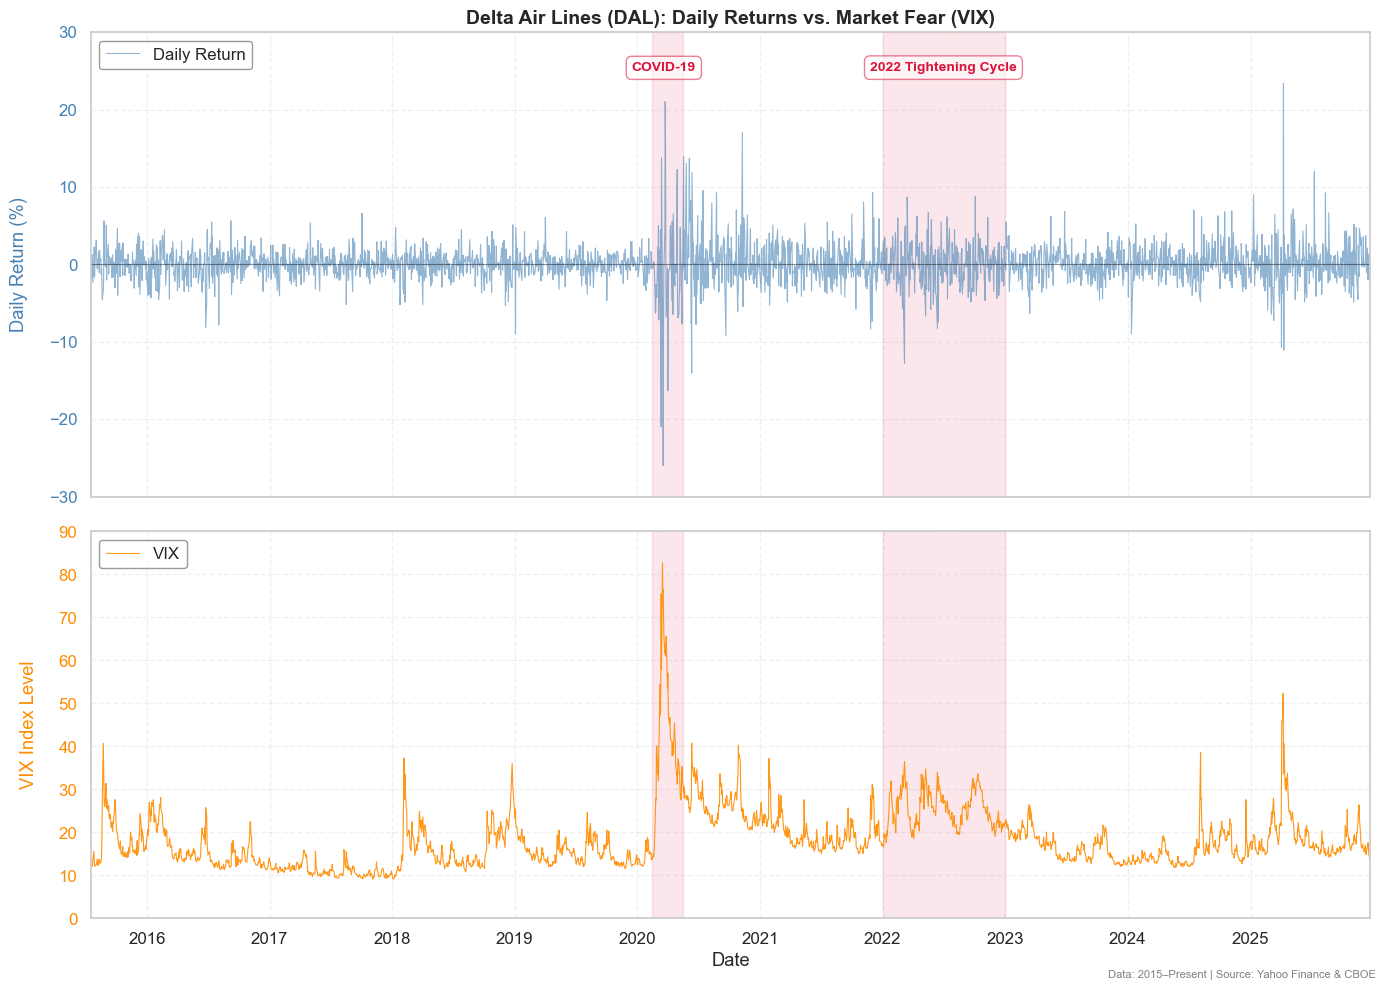

In [25]:
# Filter DAL and sort chronologically
sample = df[df['Ticker'] == 'DAL'].sort_values('Date').copy()

# Convert returns to percentage for plotting
returns_pct = sample['Return'] * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [1.2, 1]})
plt.subplots_adjust(hspace=0.02)

# Top: Daily returns
ax1.plot(sample['Date'], returns_pct, color='steelblue', alpha=0.6, linewidth=0.8, label='Daily Return')
ax1.axhline(0, color='black', linewidth=0.8, alpha=0.4)

# Set y-limits
ax1.set_ylim(-30, 30)

# Shaded event windows with labels positioned inside the plot area
ax1.axvspan(pd.to_datetime('2020-02-15'), pd.to_datetime('2020-05-15'), color='crimson', alpha=0.1)
ax2.axvspan(pd.to_datetime('2020-02-15'), pd.to_datetime('2020-05-15'), color='crimson', alpha=0.1)
ax1.text(pd.to_datetime('2020-03-20'), 25, 'COVID-19', 
         fontsize=10, color='crimson', ha='center', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='crimson', alpha=0.55))

ax1.axvspan(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-12-31'), color='crimson', alpha=0.1)
ax2.axvspan(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-12-31'), color='crimson', alpha=0.1)
ax1.text(pd.to_datetime('2022-07-01'), 25, '2022 Tightening Cycle', 
         fontsize=10, color='crimson', ha='center', fontweight='bold',
         bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='crimson', alpha=0.55))

ax1.set_ylabel("Daily Return (%)", color='steelblue', labelpad=15)
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_title("Delta Air Lines (DAL): Daily Returns vs. Market Fear (VIX)", fontweight='bold', fontsize=14)
ax1.legend(loc='upper left', frameon=True, facecolor='white', edgecolor='gray')

# Bottom: VIX 
ax2.plot(sample['Date'], sample['VIX'], color='darkorange', alpha=0.9, linewidth=0.8, label='VIX')

ax2.set_ylim(0, 90)
ax2.set_ylabel("VIX Index Level", color='darkorange', labelpad=15)
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='upper left', frameon=True, facecolor='white', edgecolor='gray')

# Format x-axis
ax2.set_xlabel("Date")
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.margins(x=0)

fig.text(0.99, 0.01, 'Data: 2015–Present | Source: Yahoo Finance & CBOE',
         ha='right', va='bottom', fontsize=8, color='gray')

plt.tight_layout()
plt.show()

Delta Air Lines (DAL) daily returns spike in magnitude during periods of elevated market volatility, with the largest swings concentrated around the COVID-19 shock and the 2022 tightening cycle. These times seem to coincide with higher VIX levels.

### Feature Distributions

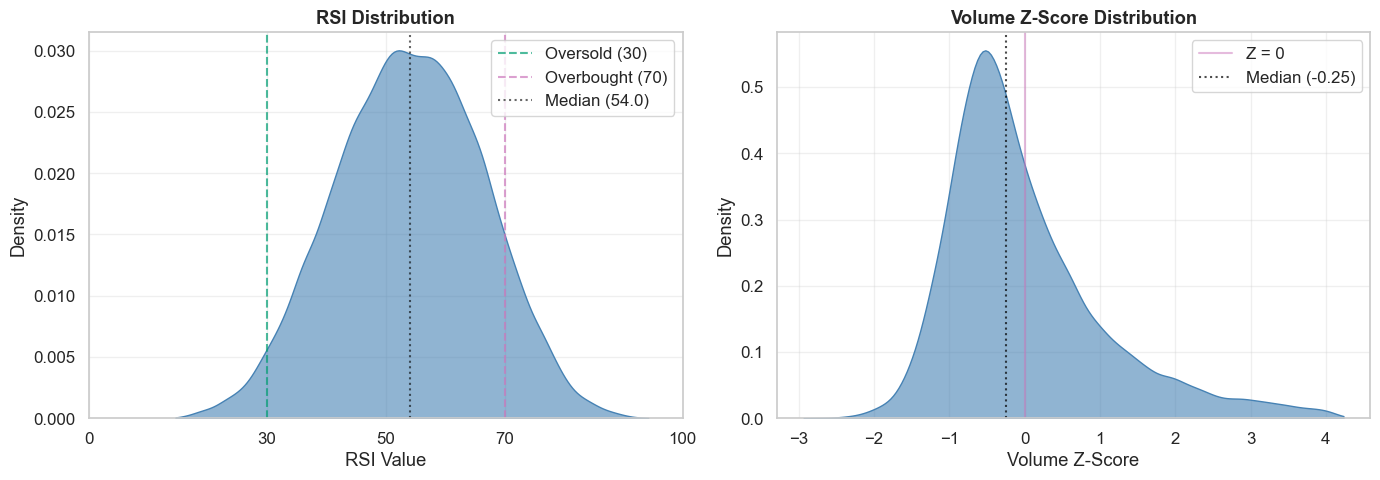

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RSI distribution with standard thresholds
sns.kdeplot(df['RSI'], ax=axes[0], fill=True, color='steelblue', alpha=0.6, cut=0)
axes[0].axvline(30, color='#029E73', linestyle='--', alpha=0.7, linewidth=1.5, label='Oversold (30)')
axes[0].axvline(70, color='#CC78BC', linestyle='--', alpha=0.7, linewidth=1.5, label='Overbought (70)')
axes[0].axvline(df['RSI'].median(), color='black', linestyle=':', alpha=0.6, linewidth=1.5, label=f"Median ({df['RSI'].median():.1f})")
axes[0].set_title("RSI Distribution", fontweight='bold')
axes[0].set_xlabel("RSI Value")
axes[0].set_ylabel("Density")
axes[0].set_xlim(0, 100)
axes[0].set_xticks([0, 30, 50, 70, 100])
axes[0].legend(frameon=True, loc='upper right')
axes[0].grid(True, alpha=0.3)

# Volume Z-Score distribution
sns.kdeplot(df['Volume_Z'], ax=axes[1], fill=True, color='steelblue', alpha=0.6, cut=0)
axes[1].axvline(0, color='#CC78BC', linestyle='-', alpha=0.5, linewidth=1.5, label='Z = 0')
axes[1].axvline(df['Volume_Z'].median(), color='black', linestyle=':', alpha=0.7, linewidth=1.5, label=f"Median ({df['Volume_Z'].median():.2f})")
axes[1].set_title("Volume Z-Score Distribution", fontweight='bold')
axes[1].set_xlabel("Volume Z-Score")
axes[1].set_ylabel("Density")
axes[1].legend(frameon=True, loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Most observations for the RSI fall in the neutral zone (30-70), with relatively few extreme oversold or overbought readings. Volume Z-Score displays a long right tail, indicating rare but extreme high-volume days that exceed typical trading activity. The median sits slightly below zero, showing us that more than half of trading days fall below the standardized mean volume.

### Sector Statistics


Sector-wise Statistical Summary (ticker-weighted)

          Avg_Return  Return_StdDev  Avg_Volatility  Pct_Up_Days  \
Sector                                                             
Airlines      0.0007         0.0289          0.0240       0.5116   
Defense       0.0006         0.0158          0.0133       0.5296   
Energy        0.0005         0.0176          0.0152       0.5128   
Finance       0.0008         0.0173          0.0145       0.5223   
Retail        0.0007         0.0137          0.0117       0.5356   
Tech          0.0015         0.0238          0.0212       0.5352   

          Pct_VolSpikes  
Sector                   
Airlines         0.2648  
Defense          0.2590  
Energy           0.2528  
Finance          0.2269  
Retail           0.1998  
Tech             0.2576  


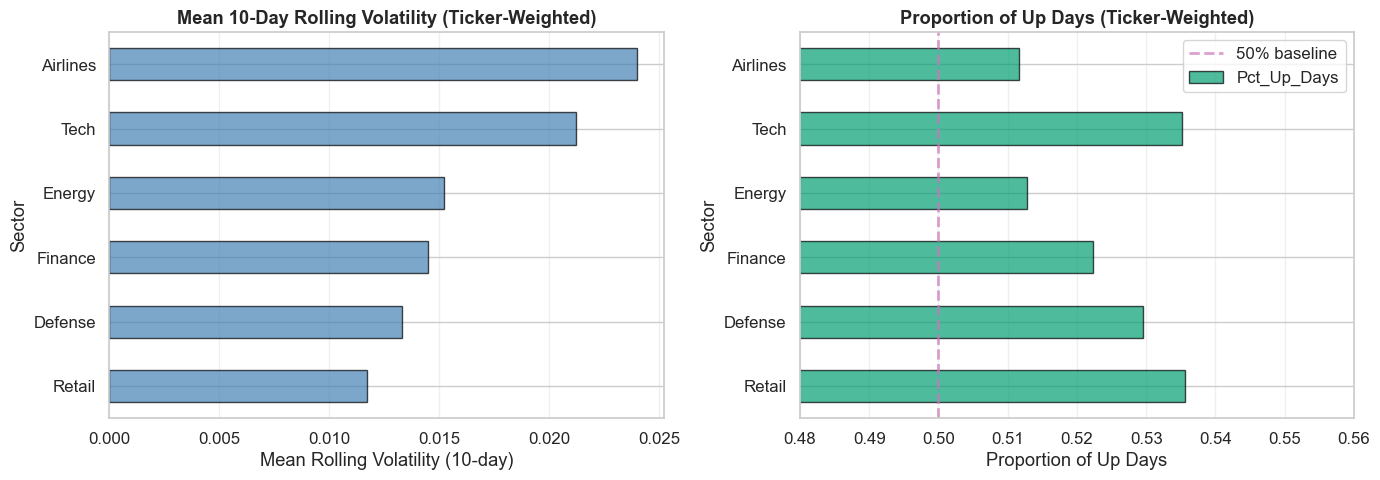

In [27]:
sectors = {
    'Tech': ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'TSLA'],
    'Finance': ['JPM'],
    'Retail': ['WMT'],
    'Airlines': ['DAL', 'UAL'],
    'Defense': ['LMT', 'RTX', 'NOC'],
    'Energy': ['XOM']
}


def get_sector(ticker):
    for sector, tickers in sectors.items():
        if ticker in tickers:
            return sector
    return 'Other'


df = df.copy()
df['Sector'] = df['Ticker'].apply(get_sector)

# Drop missing values in aggregation columns
df = df.dropna(subset=['Return', 'RollingVol', 'Direction', 'VolSpike', 'Ticker', 'Sector'])

# Two-stage aggregation: ticker-level then sector-level (ticker-weighted)
ticker_stats = df.groupby(['Ticker', 'Sector']).agg({
    'Return': ['mean', 'std'],
    'RollingVol': 'mean',
    'Direction': 'mean',
    'VolSpike': 'mean'
}).reset_index()

ticker_stats.columns = ['Ticker', 'Sector', 'Avg_Return', 'Return_StdDev', 
                        'Avg_Volatility', 'Pct_Up_Days', 'Pct_VolSpikes']

sector_stats = ticker_stats.groupby('Sector').agg({
    'Avg_Return': 'mean',
    'Return_StdDev': 'mean',
    'Avg_Volatility': 'mean',
    'Pct_Up_Days': 'mean',
    'Pct_VolSpikes': 'mean'
}).round(4)

print("\nSector-wise Statistical Summary (ticker-weighted)\n")
print(sector_stats)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Mean rolling volatility by sector
sector_stats['Avg_Volatility'].sort_values().plot(
    kind='barh', ax=ax1, color='steelblue', alpha=0.7, edgecolor='black', label='Avg_Volatility')
ax1.set_title('Mean 10-Day Rolling Volatility (Ticker-Weighted)', fontweight='bold')
ax1.set_xlabel('Mean Rolling Volatility (10-day)')
ax1.grid(True, alpha=0.3, axis='x')

# Right: Proportion of up days by sector
sector_order = sector_stats.sort_values('Avg_Volatility').index
sector_stats.loc[sector_order, 'Pct_Up_Days'].plot(
    kind='barh', ax=ax2, color='#029E73', alpha=0.7, edgecolor='black', label='Pct_Up_Days')
ax2.axvline(0.5, color='#CC78BC', linestyle='--', linewidth=2, alpha=0.7,
            label='50% baseline')
ax2.set_title('Proportion of Up Days (Ticker-Weighted)', fontweight='bold')
ax2.set_xlabel('Proportion of Up Days')
ax2.set_xlim(0.48, 0.56)
ax2.legend(frameon=True, loc='upper right')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In this sample, Airlines have the highest mean 10-day rolling volatility, while Retail is lowest. Across sectors, the proportion of up days is slightly above 50%, which is consistent with a modest positive drift over 2015–2025, though differences are very small. 

These sector summaries are ticker-weighted so each ticker contributes equally. Finance (JPM), Retail (WMT), and Energy (XOM) are single-ticker proxies, so their values should not be treated as representative of the full sector. 

### Return Distribution

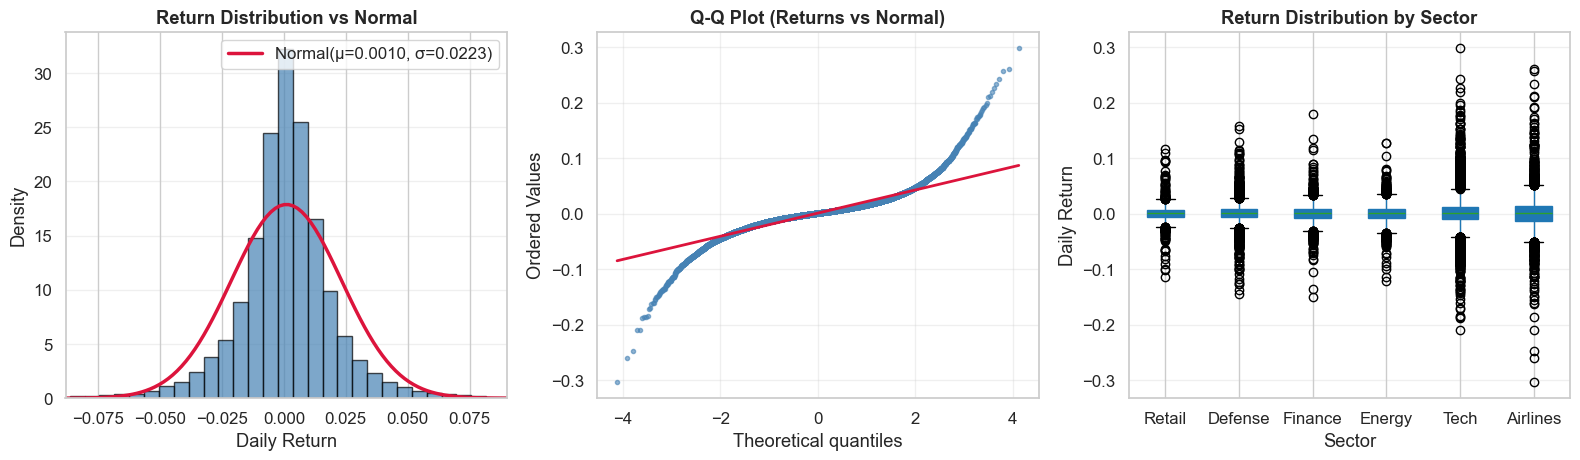

Skewness: 0.3456
Excess Kurtosis: 13.9223
Normality Test p-value: 0.0000e+00 (with n=36,778, test rejects for tiny deviations)
Practical assessment: Q-Q plot deviation + excess kurtosis ~13.9 show clear fat tails


In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

returns_clean = df['Return'].dropna()
mu, sigma = returns_clean.mean(), returns_clean.std(ddof=1)

# Histogram with fitted normal
axes[0].hist(returns_clean, bins=100, density=True, alpha=0.7,
             color='steelblue', edgecolor='black')
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), color='crimson', linewidth=2.5,
             label=f'Normal(μ={mu:.4f}, σ={sigma:.4f})')
axes[0].set_xlim(mu - 4*sigma, mu + 4*sigma)
axes[0].set_title('Return Distribution vs Normal', fontweight='bold')
axes[0].set_xlabel('Daily Return')
axes[0].set_ylabel('Density')
axes[0].legend(frameon=True)
axes[0].grid(True, alpha=0.3, axis='y')

# Q-Q plot
stats.probplot(returns_clean, dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_color('steelblue')
axes[1].get_lines()[0].set_markersize(3)
axes[1].get_lines()[0].set_alpha(0.6)
axes[1].get_lines()[1].set_color('crimson')
axes[1].get_lines()[1].set_linewidth(2)
axes[1].set_title('Q-Q Plot (Returns vs Normal)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Boxplot by sector (volatility-ordered)
sector_order = sector_stats.sort_values('Avg_Volatility').index.tolist()
df_plot = df.dropna(subset=['Return', 'Sector']).copy()
df_plot['Sector'] = pd.Categorical(df_plot['Sector'], categories=sector_order, ordered=True)
df_plot = df_plot.sort_values('Sector')

bp = df_plot.boxplot(column='Return', by='Sector', ax=axes[2], patch_artist=True)
for patch in bp.artists:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.6)
axes[2].set_title('Return Distribution by Sector', fontweight='bold')
axes[2].set_xlabel('Sector')
axes[2].set_ylabel('Daily Return')
axes[2].grid(True, alpha=0.3, axis='y')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Stats
skewness = stats.skew(returns_clean)
kurtosis = stats.kurtosis(returns_clean)
_, normality_p = stats.normaltest(returns_clean)

print(f"Skewness: {skewness:.4f}")
print(f"Excess Kurtosis: {kurtosis:.4f}")
print(f"Normality Test p-value: {normality_p:.4e} (with n={len(returns_clean):,}, test rejects for tiny deviations)")
print(f"Practical assessment: Q-Q plot deviation + excess kurtosis ~{kurtosis:.1f} show clear fat tails")

Return distributions are fat-tailed (excess kurtosis around 13.9), meaning extreme moves happen more often than a normal assumption would predict. This supports using time-based evaluation and models that stay stable in both calm and stressed periods, rather than optimizing for one quiet stretch of the market.

### Feature Correlations

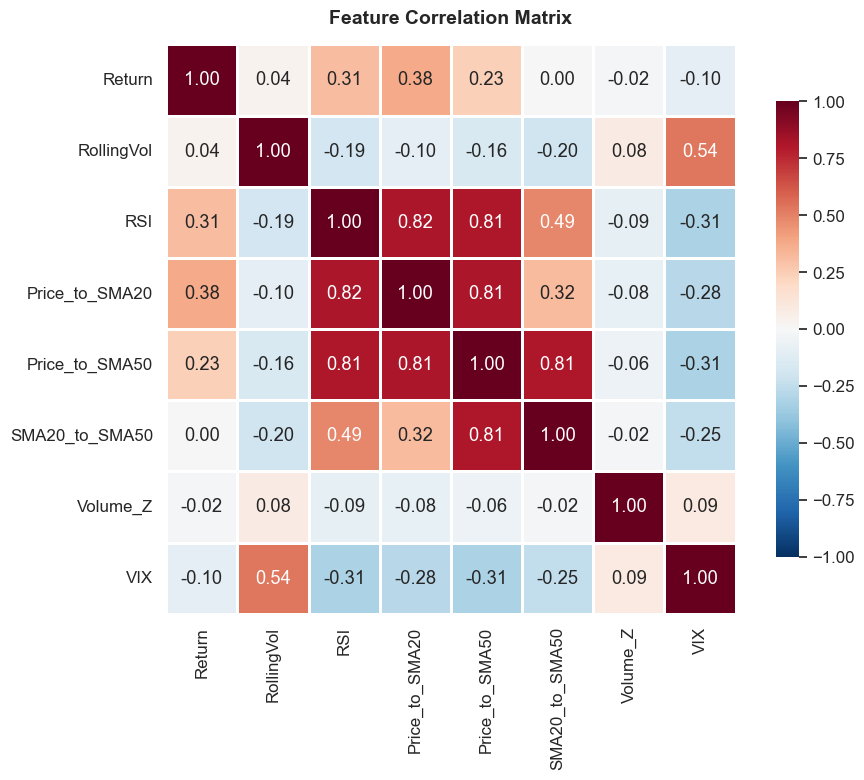

In [29]:
numeric_cols = ['Return','RollingVol','RSI','Price_to_SMA20','Price_to_SMA50','SMA20_to_SMA50','Volume_Z','VIX']
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
            vmin=-1, vmax=1)
ax.set_title("Feature Correlation Matrix", fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

### Target Balance

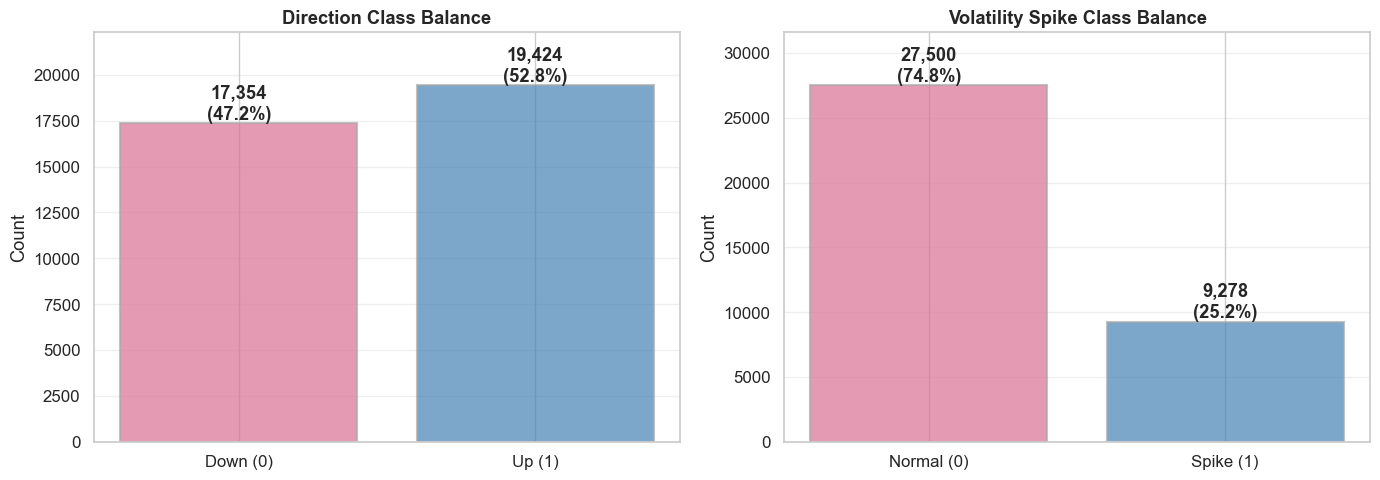

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

dir_counts = df['Direction'].value_counts().sort_index()
axes[0].bar(['Down (0)', 'Up (1)'], dir_counts.values,
            color=['palevioletred', 'steelblue'], alpha=0.7,
            edgecolor='darkgrey', linewidth=1.5)
axes[0].set_title('Direction Class Balance', fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, max(dir_counts.values) * 1.15)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(dir_counts.values):
    axes[0].text(i, v + 200, f'{v:,}\n({v/len(df)*100:.1f}%)',
                 ha='center', fontweight='bold')

vol_counts = df['VolSpike'].value_counts().sort_index()
axes[1].bar(['Normal (0)', 'Spike (1)'], vol_counts.values,
            color=['palevioletred', 'steelblue'], alpha=0.7,
            edgecolor='darkgrey', linewidth=1.5)
axes[1].set_title('Volatility Spike Class Balance', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_ylim(0, max(vol_counts.values) * 1.15)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(vol_counts.values):
    axes[1].text(i, v + 300, f'{v:,}\n({v/len(df)*100:.1f}%)',
                 ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

RSI is a weak standalone signal for next-day direction. Using classic 70/30 thresholds yields a hit rate around 53 percent, only slightly above the always-Up baseline. Any meaningful lift is more likely to come from feature interactions than from single-indicator rules.

        RSI_Zone  Pct_Up_Next_Day  Sample_Count
 Neutral (30-70)         0.527658         32161
Overbought (>70)         0.530220          3640
  Oversold (<30)         0.536336           977


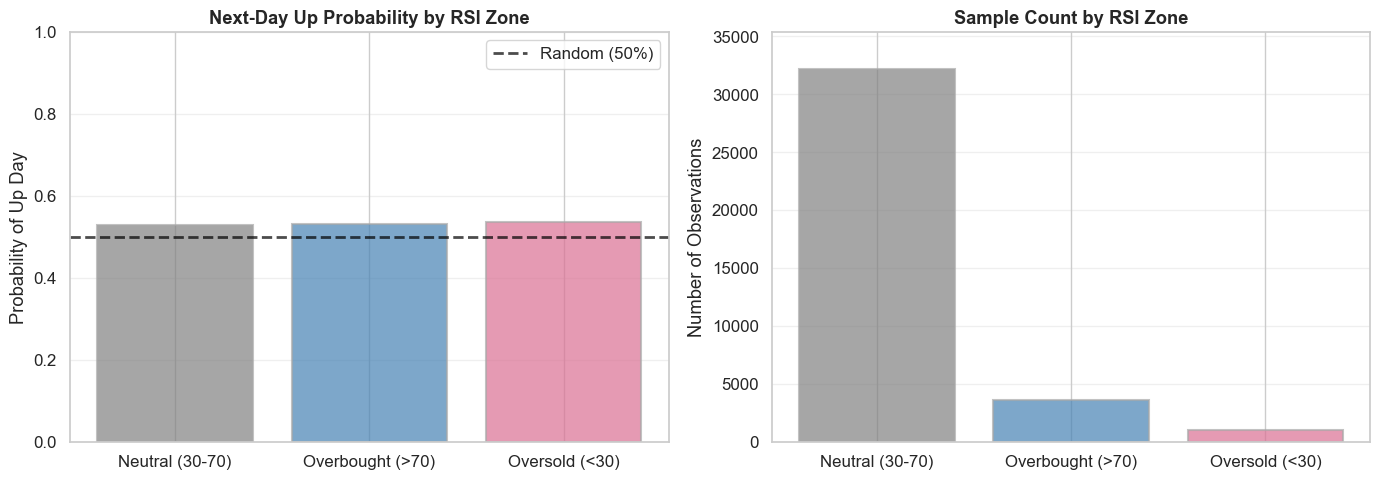

In [31]:
def categorize_rsi(rsi):
    if rsi < 30:
        return 'Oversold (<30)'
    elif rsi > 70:
        return 'Overbought (>70)'
    else:
        return 'Neutral (30-70)'


df['RSI_Zone'] = df['RSI'].apply(categorize_rsi)

# Check next-day up probability by RSI zone
rsi_signal = df.groupby('RSI_Zone')['Direction'].agg(
    ['mean', 'count']).reset_index()
rsi_signal.columns = ['RSI_Zone', 'Pct_Up_Next_Day', 'Sample_Count']
rsi_signal = rsi_signal.sort_values('Pct_Up_Next_Day')

print(rsi_signal.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

zone_colors = ['grey', 'steelblue', 'palevioletred']
ax1.bar(range(len(rsi_signal)), rsi_signal['Pct_Up_Next_Day'],
        color=zone_colors, alpha=0.7, edgecolor='darkgrey', linewidth=1.5)
ax1.set_xticks(range(len(rsi_signal)))
ax1.set_xticklabels(rsi_signal['RSI_Zone'], rotation=0)
ax1.axhline(0.5, color='black', linestyle='--', linewidth=2, alpha=0.7,
            label='Random (50%)')
ax1.set_title('Next-Day Up Probability by RSI Zone', fontweight='bold')
ax1.set_ylabel('Probability of Up Day')
ax1.set_ylim(0, 1)
ax1.legend(frameon=True)
ax1.grid(True, alpha=0.3, axis='y')

ax2.bar(range(len(rsi_signal)), rsi_signal['Sample_Count'],
        color=zone_colors, alpha=0.7, edgecolor='darkgrey', linewidth=1.5)
ax2.set_xticks(range(len(rsi_signal)))
ax2.set_xticklabels(rsi_signal['RSI_Zone'], rotation=0)
ax2.set_title('Sample Count by RSI Zone', fontweight='bold')
ax2.set_ylabel('Number of Observations')
ax2.set_ylim(0, max(rsi_signal['Sample_Count']) * 1.1)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

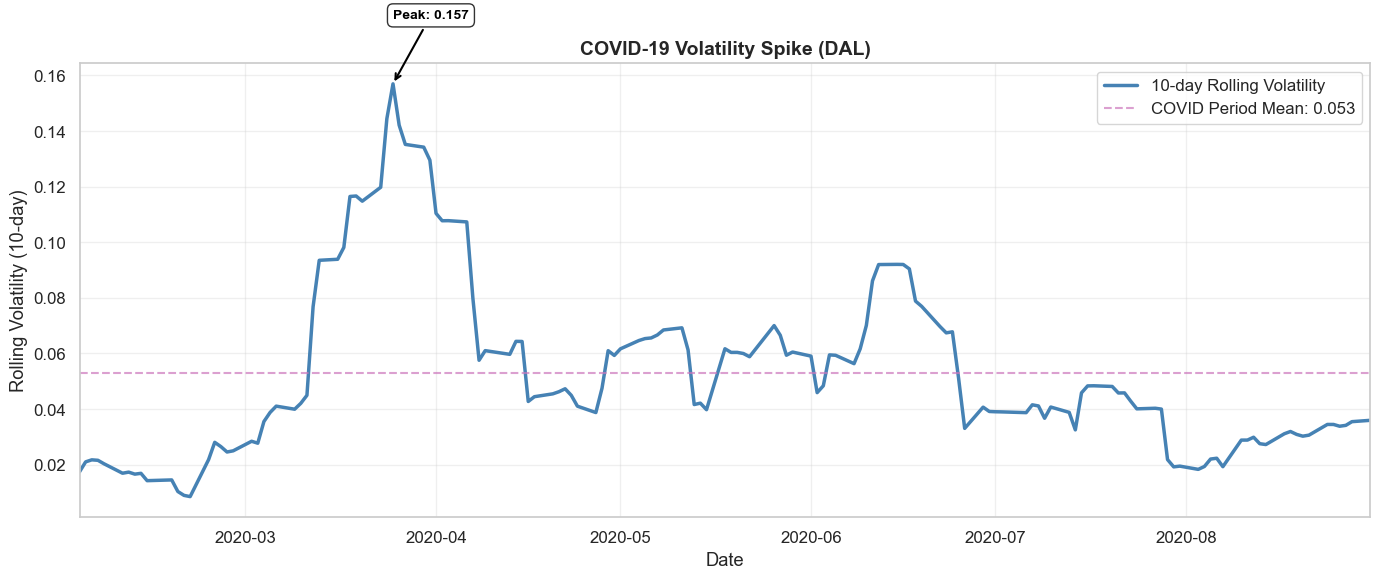

In [32]:
covid = df[(df['Date'] > '2020-02-01') & (df['Date'] < '2020-09-01') & (df['Ticker']=='DAL')]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(covid['Date'], covid['RollingVol'], color='steelblue', linewidth=2.5, label='10-day Rolling Volatility')

# Add mean volatility reference line
covid_mean = covid['RollingVol'].mean()
ax.axhline(covid_mean, color='#CC78BC', linestyle='--', linewidth=1.5, alpha=0.7, 
           label=f'COVID Period Mean: {covid_mean:.3f}')

# Annotate peak
if not covid.empty:
    peak = covid.loc[covid['RollingVol'].idxmax()]
    ax.annotate(
        f"Peak: {peak['RollingVol']:.3f}",
        xy=(peak['Date'], peak['RollingVol']),
        xytext=(peak['Date'], peak['RollingVol'] * 1.15),
        arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
        fontsize=10,
        color='black',
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='black', alpha=0.8)
    )

ax.set_title("COVID-19 Volatility Spike (DAL)", fontweight='bold', fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Rolling Volatility (10-day)")
ax.legend(frameon=True, loc='upper right')
ax.grid(True, alpha=0.3)
ax.margins(x=0)
plt.tight_layout()
plt.show()

### Volatility Market Environments

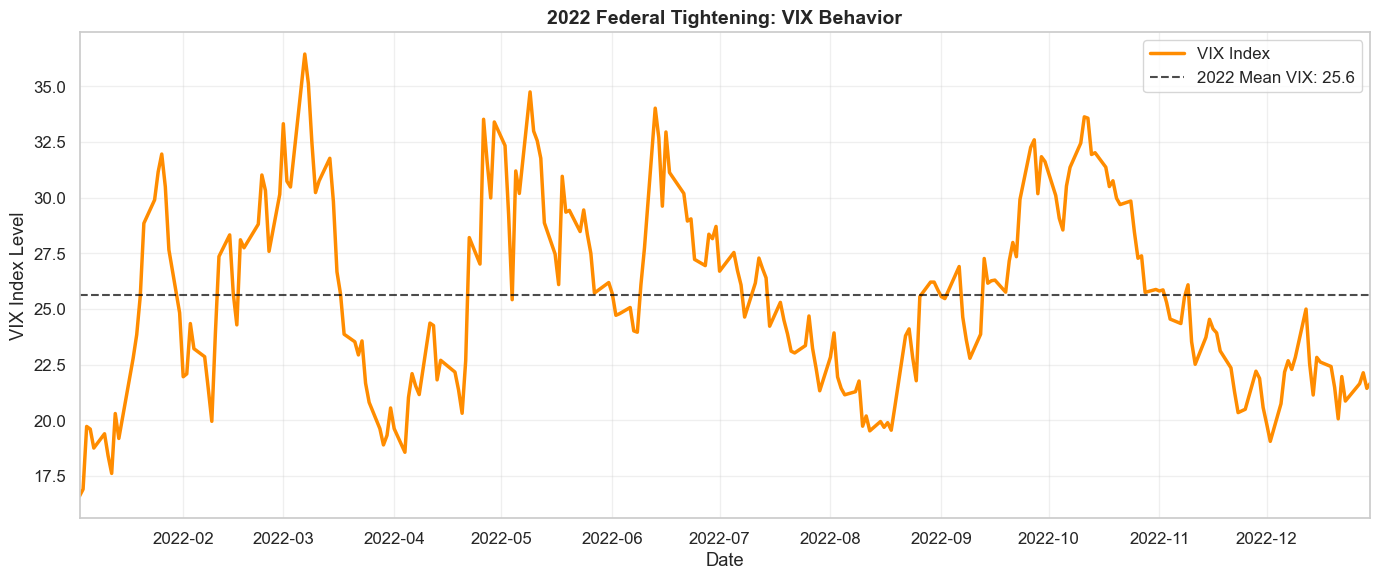

In [33]:
taper = df[(df['Date'] > '2022-01-01') & (df['Date'] < '2022-12-31') & (df['Ticker']=='DAL')]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(taper['Date'], taper['VIX'], color='darkorange', linewidth=2.5, label='VIX Index')

# Add mean line
taper_mean = taper['VIX'].mean()
ax.axhline(taper_mean, color='black', linestyle='--', linewidth=1.5, alpha=0.7,
           label=f"2022 Mean VIX: {taper_mean:.1f}")

ax.set_title("2022 Federal Tightening: VIX Behavior", fontweight='bold', fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("VIX Index Level")
ax.legend(frameon=True, loc='upper right')
ax.grid(True, alpha=0.3)
ax.margins(x=0)
plt.tight_layout()
plt.show()

### Key Takeaways and Modeling Strategy

EDA revealed:
- Volatility clusters and is environment-like, with sustained high-volatility periods during major market stress (not just isolated one-day events). Models should be stress-tested on these windows rather than evaluated only on calm periods.
- Returns are heavy-tailed and noisy, so performance should be judged by stability over time and against simple baselines, not by a single best-case score.
- VolSpike is meaningfully imbalanced, so spike detection needs metrics that reflect rare-event performance (precision/recall and PR-AUC), plus careful threshold selection.

Future modeling decisions:
- Use time-based evaluation (walk-forward or expanding-window) and report results across multiple windows, including crisis periods as explicit stress tests.
- Start with simple baselines and regularized models, then move to nonlinear models (tree ensembles) to capture feature interactions if they add consistent lift.
- Handle spike imbalance with class weights, calibrated probabilities, and threshold tuning. Avoid any resampling method unless it is applied strictly within each training split.

Next steps:
- Train baseline models for Direction and VolSpike using walk-forward splits.
- Inspect feature importance and error patterns across time windows.
- Validate robustness during high-volatility market environments.